In [99]:
!python -m pip install -U pip
!nltk.download(vader_lexicon)

/bin/bash: -c: line 0: syntax error near unexpected token `vader_lexicon'
/bin/bash: -c: line 0: `nltk.download(vader_lexicon)'


In [14]:
!pip install pandas
!pip install sklearn
!pip install numpy
!pip install python-binance
!pip install python-dotenv
!pip install bta-lib
!pip install matplotlib
!pip install pytrends

     |████████████████████████████████| 5.5 MB 10.0 MB/s eta 0:00:01     |████████▏                       | 1.4 MB 10.0 MB/s eta 0:00:01     |██████████████▋                 | 2.5 MB 10.0 MB/s eta 0:00:01     |███████████████████▎            | 3.3 MB 10.0 MB/s eta 0:00:01     |████████████████████████▍       | 4.2 MB 10.0 MB/s eta 0:00:01     |██████████████████████████████  | 5.2 MB 10.0 MB/s eta 0:00:01


In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
import pickle
from datetime import datetime


import pandas as pd
import numpy as np
from datetime import datetime
from binance.client import Client
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor
from datetime import datetime
import btalib

pd.set_option('display.max_rows', 500)

In [3]:
import logging

# Gets or creates a logger
logger = logging.getLogger(__name__)  

# set log level
logger.setLevel(logging.INFO)

# define file handler and set formatter
file_handler = logging.FileHandler('logfile.log')
formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

In [4]:
# init
api_key = os.environ.get('BINANCE_API')
api_secret = os.environ.get('BINANCE_SECRET')

client = Client(api_key, api_secret)

print(client.get_account())
print(client.get_asset_balance(asset='BTC'))
print(client.get_all_tickers())

{'makerCommission': 10, 'takerCommission': 10, 'buyerCommission': 0, 'sellerCommission': 0, 'canTrade': True, 'canWithdraw': True, 'canDeposit': True, 'updateTime': 1618173055044, 'accountType': 'SPOT', 'balances': [], 'permissions': ['SPOT']}
None
[{'symbol': 'ETHBTC', 'price': '0.04487900'}, {'symbol': 'LTCBTC', 'price': '0.00459400'}, {'symbol': 'BNBBTC', 'price': '0.01005720'}, {'symbol': 'NEOBTC', 'price': '0.00163400'}, {'symbol': 'QTUMETH', 'price': '0.00530800'}, {'symbol': 'EOSETH', 'price': '0.00232700'}, {'symbol': 'SNTETH', 'price': '0.00005697'}, {'symbol': 'BNTETH', 'price': '0.00264600'}, {'symbol': 'BCCBTC', 'price': '0.07908100'}, {'symbol': 'GASBTC', 'price': '0.00022990'}, {'symbol': 'BNBETH', 'price': '0.22410000'}, {'symbol': 'BTCUSDT', 'price': '50081.92000000'}, {'symbol': 'ETHUSDT', 'price': '2247.83000000'}, {'symbol': 'HSRBTC', 'price': '0.00041400'}, {'symbol': 'OAXETH', 'price': '0.00017780'}, {'symbol': 'DNTETH', 'price': '0.00002801'}, {'symbol': 'MCOETH',

In [5]:
coin_list = [ \
"ETH" + "USDT" ,
"BNB"+ "USDT",
"XRP"+ "USDT",
"USDT"+ "USDT",
"DOGE"+ "USDT",
"ADA"+ "USDT",
"DOT"+ "USDT",
"LTC"+ "USDT",
"BCH"+ "USDT",
"UNI"+ "USDT",
"LINK"+ "USDT",
"VET"+ "USDT",
"XLM"+ "USDT",
"USDC"+ "USDT",
"THETA"+ "USDT",
"FIL"+ "USDT",
"TRX"+ "USDT",
"WBTC"+ "USDT",
"SOL"+ "USDT",
"EOS"+ "USDT",
"KLAY"+ "USDT",
"NEO"+ "USDT",
"BSV"+ "USDT",
"XMR"+ "USDT"
]

In [5]:
for coin in coin_list:    
    print(coin + ":")
    #[x for x in client.get_all_tickers() if (x.get('symbol')+"USDT").startswith("XRP")]
    print([x for x in client.get_all_tickers() if x.get('symbol') == coin ])
    print("*****")

NameError: name 'coin_list' is not defined

In [9]:
def f_initial_load(coinlist):

    dict_all = {}
    for coin in coin_list:  
        dict_coin = {}    
        logger.info('Initial load {x}'.format(x=coin))
        try:
            klines = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1HOUR, "1 Dec, 2017", "21 Apr, 2021")
        except:
            logger.error('Initial load {x} FAILED'.format(x=coin))
            continue
        for x in klines:
            ts = int(x[0]) / 1000
            dt = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
            dict_coin.update({dt:[x[0], x[4], x[5], x[8]]}) #date, price, volume, numoftrades    
        dict_all.update({coin:dict_coin})
        
    pickle_out = open("dict_all.pkl","wb")
    pickle.dump(dict_all, pickle_out)
    pickle_out.close()

    return dict_all


In [8]:
dict_all_coins = f_initial_load(coin_list)

NameError: name 'f_initial_load' is not defined

In [6]:
# fetch 1 minute klines for the last day up until now
def f_update_coins(coinlist, dict_all=None):
    
    if dict_all is None:
        file = open("dict_all.pkl","rb")
        dict_all = pickle.load(file)

    for coin in list(dict_all.keys()):  
        dict_coin = {}
        logger.info('try to update coin {x}'.format(x=coin))
        
        try:
            klines = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1HOUR, "2 day ago UTC")
        except:
            logger.error('UPDATE list of coin: {x} FAILED, seems no info'.format(x=coin))
            ##Make warning to say that such coin data is not up-to-date!!
            continue        
        dict_coin = dict_all.get(coin)
        for x in klines:
            ts = int(x[0]) / 1000
            dt = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
            dict_coin.update({dt:[x[0], x[4], x[5], x[8]]}) #date, price, volume, numoftrades    
        dict_all.update({coin:dict_coin})
    pickle_out = open("dict_all.pkl","wb")
    pickle.dump(dict_all, pickle_out)
    pickle_out.close()

    return dict_all


In [7]:
#dict_all_coins = f_update_coins(coin_list, dict_all_coins)
dict_all_coins = f_update_coins(coin_list, dict_all = None)

In [12]:
dict_all_coins.get( "LINKUSDT")

{'2019-01-16 10:00:00': [1547632800000, '0.50660000', '63365.33000000', 151],
 '2019-01-16 11:00:00': [1547636400000, '0.49800000', '153229.70000000', 296],
 '2019-01-16 12:00:00': [1547640000000, '0.48870000', '185102.78000000', 315],
 '2019-01-16 13:00:00': [1547643600000, '0.48690000', '67053.33000000', 198],
 '2019-01-16 14:00:00': [1547647200000, '0.47460000', '168009.30000000', 360],
 '2019-01-16 15:00:00': [1547650800000, '0.47900000', '83996.24000000', 251],
 '2019-01-16 16:00:00': [1547654400000, '0.48000000', '78048.67000000', 228],
 '2019-01-16 17:00:00': [1547658000000, '0.50430000', '132251.61000000', 443],
 '2019-01-16 18:00:00': [1547661600000, '0.50160000', '58508.99000000', 199],
 '2019-01-16 19:00:00': [1547665200000, '0.50410000', '67946.15000000', 147],
 '2019-01-16 20:00:00': [1547668800000, '0.51270000', '102787.08000000', 275],
 '2019-01-16 21:00:00': [1547672400000, '0.51170000', '25010.78000000', 108],
 '2019-01-16 22:00:00': [1547676000000, '0.48580000', '7399

In [8]:
df_all_coins = pd.DataFrame(columns= ["coin", "dt", "price", "vol", "tradefreq"])
for coin in dict_all_coins.keys():
    dict_coin = dict_all_coins.get(coin)
    listx = []
    for dt in dict_coin.keys():
        listx.append([coin, dt, dict_coin.get(dt)[1], dict_coin.get(dt)[2], dict_coin.get(dt)[3]])
    df_all_coins = df_all_coins.append(pd.DataFrame(data = listx,
                                     columns= ["coin", "dt", "price", "vol", "tradefreq"]
                                    )
                       )
df_all_coins.dt = df_all_coins.dt.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')  )

df_all_coins['last_time'] = 0
for coin in df_all_coins.coin.unique():
    max_dt = np.max(df_all_coins.loc[df_all_coins.coin == coin, 'dt'])
    df_all_coins.loc[(df_all_coins.coin == coin) & (df_all_coins.dt == max_dt ) , 'last_time'] = 1

df_all_coins.set_index("dt", drop=True, inplace = True )
df_all_coins.sort_index(inplace=True)
df_all_coins["is_day_end"] = 0
df_all_coins.loc[[True if x.strftime("%H:%M:%S") == '00:00:00' else False for x in list(df_all_coins.index)], "is_day_end"] = 1  
df_all_coins.price = df_all_coins.price.astype(float)
df_all_coins.tradefreq= df_all_coins.tradefreq.astype(float)
df_all_coins.vol= df_all_coins.vol.astype(float)
df_all_coins.tail()




,coin,price,vol,tradefreq,last_time,is_day_end
dt,,,,,,
2021-04-24 16:00:00,ADAUSDT,1.12892,7.479559e+06,8754.0,1,0
2021-04-24 16:00:00,DOGEUSDT,0.27200,1.516782e+08,40461.0,1,0
2021-04-24 16:00:00,XRPUSDT,1.07389,1.713112e+07,16382.0,1,0
2021-04-24 16:00:00,LINKUSDT,32.14610,1.265531e+05,5633.0,1,0
2021-04-24 16:00:00,XMRUSDT,368.65000,2.296475e+03,1852.0,1,0


In [12]:
df_all_coins

,coin,price,vol,tradefreq,last_time,is_day_end,next1price,next2price,next3price,Target
dt,,,,,,,,,,
2017-12-01 00:00:00,ETHUSDT,421.42000,1.325873e+03,956.0,0,1,417.9800,442.4300,460.320,440.243333
2017-12-01 00:00:00,BNBUSDT,1.91130,1.629423e+04,105.0,0,1,1.9488,2.0500,2.100,2.032933
2017-12-01 00:00:00,NEOUSDT,31.87900,3.958592e+03,203.0,0,1,33.7980,34.7230,35.702,34.741000
2017-12-01 01:00:00,ETHUSDT,421.72000,1.532115e+03,1037.0,0,0,418.8000,456.3200,467.370,447.496667
2017-12-01 01:00:00,BNBUSDT,1.95000,1.354769e+04,103.0,0,0,1.9698,2.1383,2.084,2.064033
...,...,...,...,...,...,...,...,...,...,...
2021-04-24 15:00:00,ADAUSDT,1.12931,2.090773e+07,24090.0,1,0,NaN,NaN,NaN,0.000000
2021-04-24 15:00:00,DOGEUSDT,0.27152,2.751377e+08,73854.0,1,0,NaN,NaN,NaN,0.000000
2021-04-24 15:00:00,XRPUSDT,1.06982,5.117500e+07,40894.0,1,0,NaN,NaN,NaN,0.000000


In [9]:
df_all_coins["next1price"] = df_all_coins.groupby(['coin'])['price'].shift(-6)
df_all_coins["next2price"] = df_all_coins.groupby(['coin'])['price'].shift(-12)
df_all_coins["next3price"] = df_all_coins.groupby(['coin'])['price'].shift(-24)

df_all_coins["Target"] = 0

def set_target(row, margin):
    meanx = np.nanmean([row["next1price"], row["next2price"], row["next3price"] ])
    if meanx > row["price"] * (1.00 + margin):
        return 1
    elif meanx < row["price"] * (1.00 - margin):
        return -1
    else:
        return 0

    
def set_target_numeric(row):
    return np.nanmean([row["next1price"], row["next2price"], row["next3price"] ])
        
Target_Type = 'Binary'
    
if Target_Type == 'Numeric':    
    #Numeric Target
    df_all_coins.loc[df_all_coins.last_time == 0, "Target"] = \
            df_all_coins.loc[df_all_coins.last_time == 0, :].apply(lambda row: set_target_numeric(row), axis = 1)    
else:
    #Binary Target
    df_all_coins.loc[df_all_coins.last_time == 0, "Target"] = \
            df_all_coins.loc[df_all_coins.last_time == 0, :].apply(lambda row: set_target(row, 0.03), axis = 1)


    

/root/projects/binance_first/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [10]:
for coin in df_all_coins.coin.unique():
    index_t = (df_all_coins.coin == coin)
    df_all_coins.loc[index_t, 'ma12'] = btalib.sma(df_all_coins.loc[index_t, 'price'], period=12).df.values.tolist()
    df_all_coins.loc[index_t, 'ma24'] = btalib.sma(df_all_coins.loc[index_t, 'price'], period=24).df.values.tolist()
    df_all_coins.loc[index_t, 'ma48'] = btalib.sma(df_all_coins.loc[index_t, 'price'], period=48).df.values.tolist()
    #df_all_coins.loc[index_t, 'ma148'] = btalib.sma(df_all_coins.loc[index_t, 'price'], period=96).df.values.tolist()
    df_all_coins.loc[index_t, 'rsi14'] = btalib.rsi(df_all_coins.loc[index_t, 'price'], period=14).df.values.tolist()
    df_all_coins.loc[index_t, 'rsi28'] = btalib.rsi(df_all_coins.loc[index_t, 'price'], period=28).df.values.tolist()
    df_all_coins.loc[index_t, 'rsi42'] = btalib.rsi(df_all_coins.loc[index_t, 'price'], period=42).df.values.tolist()
    df_all_coins.loc[index_t, ["macd12", "signal12", "hist12"] ] =  \
                    btalib.macd(df_all_coins.loc[index_t, 'price'], pfast=12, pslow=24, psignal=9).df.values.tolist()




df_all_coins.loc[df_all_coins.coin == 'DOGEUSDT', :].Target.value_counts()



 0    12537
 1     1699
-1     1552
Name: Target, dtype: int64

In [14]:
df_all_coins.loc[df_all_coins.coin == 'USDCUSDT', :].tail(100)

,coin,price,vol,tradefreq,last_time,is_day_end,next1price,next2price,next3price,Target,ma12,ma24,ma48,rsi14,rsi28,rsi42,macd12,signal12,hist12
dt,,,,,,,,,,,,,,,,,,,
2021-04-20 12:00:00,USDCUSDT,0.9991,8794317.57,3010.0,0,0,0.9992,0.9991,0.9993,0.999200,0.998975,0.998979,0.998715,53.855510,52.106037,51.115909,7.294441e-05,6.970387e-05,3.240534e-06
2021-04-20 13:00:00,USDCUSDT,0.9988,10244404.12,2404.0,0,0,0.9993,0.9994,0.9993,0.999333,0.998933,0.998971,0.998725,48.137945,49.775543,49.687746,5.270771e-05,6.630464e-05,-1.359693e-05
2021-04-20 14:00:00,USDCUSDT,0.9992,8958797.96,2982.0,0,0,0.9994,0.9991,0.9995,0.999333,0.998975,0.998992,0.998742,54.998118,52.700690,51.537162,6.584398e-05,6.621251e-05,-3.685325e-07
2021-04-20 15:00:00,USDCUSDT,0.9994,14454518.91,3505.0,0,0,0.9991,0.9991,0.9992,0.999133,0.999033,0.999004,0.998771,57.990311,54.087223,52.432742,9.002889e-05,7.097579e-05,1.905311e-05
2021-04-20 16:00:00,USDCUSDT,0.9993,15178333.49,3887.0,0,0,0.9990,0.9993,0.9995,0.999267,0.999067,0.999008,0.998794,55.985875,53.277414,51.941108,1.003633e-04,7.685328e-05,2.350998e-05
2021-04-20 17:00:00,USDCUSDT,0.9988,12247021.88,2716.0,0,0,0.9990,0.9992,0.9996,0.999267,0.999058,0.998987,0.998800,47.200883,49.439243,49.560903,7.024985e-05,7.553259e-05,-5.282745e-06
2021-04-20 18:00:00,USDCUSDT,0.9992,6588404.38,2063.0,0,0,0.9991,0.9995,0.9996,0.999400,0.999075,0.998996,0.998817,53.488651,52.290710,51.386543,7.548157e-05,7.552239e-05,-4.082307e-08
2021-04-20 19:00:00,USDCUSDT,0.9993,9630795.47,3139.0,0,0,0.9994,0.9993,0.9993,0.999333,0.999092,0.998996,0.998825,54.933584,52.978234,51.833023,8.600987e-05,7.761988e-05,8.389982e-06
2021-04-20 20:00:00,USDCUSDT,0.9994,23204780.12,4405.0,0,0,0.9991,0.9993,0.9994,0.999267,0.999133,0.999012,0.998838,56.392514,53.670601,52.281969,1.005318e-04,8.220226e-05,1.832951e-05


## Classification

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")


list_all = []
for coin in df_all_coins.coin.unique():

    clf = RandomForestClassifier(n_estimators=10 ,random_state=0, max_depth = 5, class_weight = "balanced")

    #df_tmp = df_all_coins.copy()
    df_tmp = df_all_coins.loc[df_all_coins.coin ==coin, : ]
    df_tmp.dropna(inplace = True)
    y = df_tmp.loc[:, ["Target"]]
    X = df_tmp.loc[:, [ x for x in df_tmp.columns if x not in (["Target", "coin", "next1price", "next2price", "next3price"])  ]]

    df_tmp.loc[:, ["Target"]]
    
    clf.fit(X , y)
    y_pred = clf.predict(X)
    #print(classification_report(y, y_pred))
    #print(confusion_matrix(y, y_pred))
    list_all.append([coin, 
                     f1_score(y, y_pred, average='macro'),
                     f1_score(y, df_tmp["macd12"].apply(lambda x: 1 if x > 0.01 else  (-1 if x < -0.01 else 0 ) ), average='macro')])
    
    del df_tmp
    
    #print(coin + " - " +  str(f1_score(y, y_pred, average='macro')))
pd.DataFrame(data = list_all, columns = ["coin", "model", "baseline"]).sort_values(by="model", ascending = False)    


,coin,model,baseline
10,USDCUSDT,1.000000,0.499951
19,FILUSDT,0.630405,0.227999
14,DOGEUSDT,0.569720,0.312401
18,UNIUSDT,0.530109,0.295395
17,DOTUSDT,0.529455,0.267445
16,SOLUSDT,0.515703,0.294309
5,XRPUSDT,0.503361,0.370623
1,BNBUSDT,0.484569,0.210604
15,BCHUSDT,0.480929,0.144659
2,NEOUSDT,0.480101,0.232973


In [25]:
    df_tmp = df_all_coins.loc[df_all_coins.coin ==coin, : ]
    df_tmp.dropna(inplace = True)
df_tmp["macd12"].apply(lambda x: 1 if x > 0 else  (-1 if x < 0 else 0 ) )

dt
2020-10-17 16:00:00   -1
2020-10-17 17:00:00   -1
2020-10-17 18:00:00   -1
2020-10-17 19:00:00   -1
2020-10-17 20:00:00   -1
                      ..
2021-04-23 11:00:00   -1
2021-04-23 12:00:00   -1
2021-04-23 13:00:00   -1
2021-04-23 14:00:00   -1
2021-04-23 15:00:00   -1
Name: macd12, Length: 4503, dtype: int64

## Regression

In [15]:
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")


list_all = []
for coin in df_all_coins.coin.unique():

    clf = RandomForestRegressor(n_estimators=10 ,random_state=0, max_depth = 10)

    #df_tmp = df_all_coins.copy()
    df_tmp = df_all_coins.loc[df_all_coins.coin ==coin, : ]
    df_tmp.dropna(inplace = True)
    y = df_tmp.loc[:, ["Target"]]
    X = df_tmp.loc[:, [ x for x in df_tmp.columns if x not in (["Target", "coin", "next1price", "next2price", "next3price"])  ]]

    clf.fit(X , y)
    y_pred = clf.predict(X)
    #print(classification_report(y, y_pred))
    #print(confusion_matrix(y, y_pred))
    list_all.append([coin, r2_score(y, y_pred), r2_score(y, df_tmp.loc[:, ["ma12"]])  ])
    #print(coin + " - " +  str(f1_score(y, y_pred, average='macro')))
    
    del df_tmp
    
pd.DataFrame(data = list_all, columns = ["coin", "MODEL", "BASELINE"]).sort_values(by="MODEL", ascending = False)    


,coin,MODEL,BASELINE
1,BNBUSDT,0.999763,0.994814
4,ADAUSDT,0.999691,0.996443
13,THETAUSDT,0.999680,0.994976
9,VETUSDT,0.999625,0.990931
19,FILUSDT,0.999594,0.986912
14,DOGEUSDT,0.999581,0.963134
16,SOLUSDT,0.999572,0.992597
17,DOTUSDT,0.999481,0.994226
0,ETHUSDT,0.999420,0.996216
11,LINKUSDT,0.999358,0.995555


<BarContainer object of 14 artists>

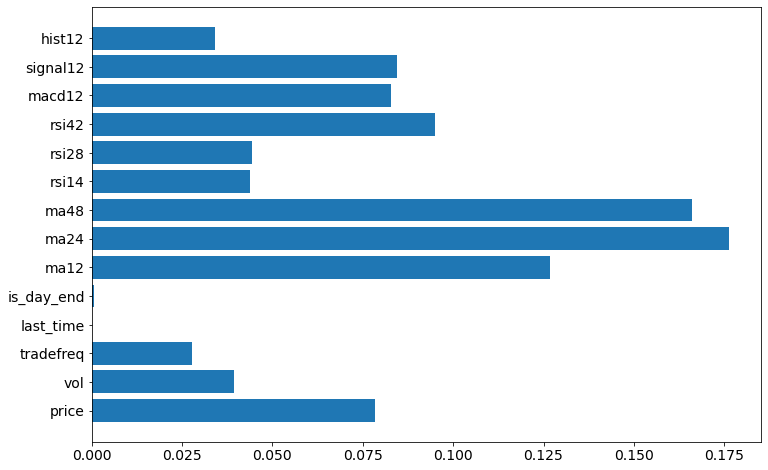

In [22]:
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

plt.barh(X.columns, clf.feature_importances_)


#from sklearn.metrics import f1_score
#f1_score(y, y_pred, average='macro')

In [150]:
index_t = (df_all_coins.coin == 'DOGEUSDT')
df_all_coins.loc[index_t, :]
btalib.sma(df_all_coins.loc[index_t, 'price'], period=48).df.values.tolist()    
#btalib.sma(df_all_coins.loc[index_t, 'price'], period=48).df  


[[nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [nan],
 [0.0036205083333333333],
 [0.003611364583333333],
 [0.0036038479166666665],
 [0.0035965687499999997],
 [0.00359078125],
 [0.0035864833333333333],
 [0.003586008333333333],
 [0.0035836541666666665],
 [0.0035806916666666663],
 [0.0035774104166666665],
 [0.003574385416666667],
 [0.0035699208333333336],
 [0.003562995833333334],
 [0.0035569958333333336],
 [0.0035526875000000003],
 [0.0035481604166666667],
 [0.0035422770833333336],
 [0.0035369562500000007],
 [0.003532212500000001],
 [0.0035285625000000004],
 [0.003524583333333334],
 [0.003522083333333334],
 [0.003519427083333334],
 [0.003517227083333334],
 [0.0035154333333

In [141]:
df_all_coins.loc[df_all_coins.coin == 'DOGEUSDT', :].head(100)

,coin,price,vol,tradefreq,last_time,is_day_end,next1price,next2price,Target,ma48
dt,,,,,,,,,,
2019-07-05 12:00:00,DOGEUSDT,0.003925,949430724.0,6487.0,0,0,0.003640,0.003819,0,NaN
2019-07-05 13:00:00,DOGEUSDT,0.003835,159004267.0,1529.0,0,0,0.003688,0.003747,0,NaN
2019-07-05 14:00:00,DOGEUSDT,0.003841,105517060.0,1241.0,0,0,0.003711,0.003740,0,NaN
2019-07-05 15:00:00,DOGEUSDT,0.003738,100804728.0,1213.0,0,0,0.003710,0.003767,0,NaN
2019-07-05 16:00:00,DOGEUSDT,0.003666,120261079.0,1416.0,0,0,0.003743,0.003745,0,NaN
2019-07-05 17:00:00,DOGEUSDT,0.003628,148274922.0,1624.0,0,0,0.003870,0.003707,0,NaN
2019-07-05 18:00:00,DOGEUSDT,0.003640,58947455.0,820.0,0,0,0.003819,0.003641,0,NaN
2019-07-05 19:00:00,DOGEUSDT,0.003688,73100952.0,974.0,0,0,0.003747,0.003660,0,NaN
2019-07-05 20:00:00,DOGEUSDT,0.003711,42377075.0,770.0,0,0,0.003740,0.003619,0,NaN


In [7]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

# get timestamp of earliest date data is available
timestamp = client._get_earliest_valid_timestamp('DOGEUSDT', '1d')

# request historical candle (or klines) data
klines = client.get_historical_klines("DOGEUSDT", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

In [ ]:
timestamp = client._get_earliest_valid_timestamp('BTCUSDT', '1d')
timestamp

In [10]:
klines[-1]




[1618685700000,
 '0.27480000',
 '0.27489960',
 '0.27414070',
 '0.27449730',
 '832363.00000000',
 1618685759999,
 '228516.22384700',
 318,
 '363595.00000000',
 '99811.79834750',
 '0']

In [21]:
from datetime import datetime
ts = int("1618531200000") / 1000

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2021-04-16 00:00:00
